# 1. Imports and Data Loading.

In [120]:
from basic_functions import data_load
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [121]:
X_train_raw = data_load("data/X_train.csv")
y_train = data_load("data/y_train_clustered.csv")

Data loaded!
Data loaded!


# 2. Feature Importance

## 2.1 Unique Values

Dataframe with count of unique values for each Feature.

In [122]:
counts = {}
for key in X_train_raw.columns:
    counts[key] = X_train_raw[key].nunique()
df_counts = pd.DataFrame(list(counts.items()), columns=["Feature", "UniqueValues"])

## 2.2 MI-Scores

MI-Scores for each Feature.

In [123]:
from sklearn.feature_selection import mutual_info_classif
import pandas as pd

# Nur auf Trainingsdaten!
mi_scores = mutual_info_classif(X_train_raw, y_train, discrete_features=True, random_state=42)
mi_series = pd.Series(mi_scores, index=X_train_raw.columns)
mi_df = mi_series.reset_index()
mi_df.columns = ["Feature", "MI_Score"]

c:\Users\timmn\OneDrive\Dokumente\GitHub\Probabilistic-Machine-Learning_lecture-PROJECTS\projects\13-3NTXXXX_microcensus_income\venv\Lib\site-packages\sklearn\utils\validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


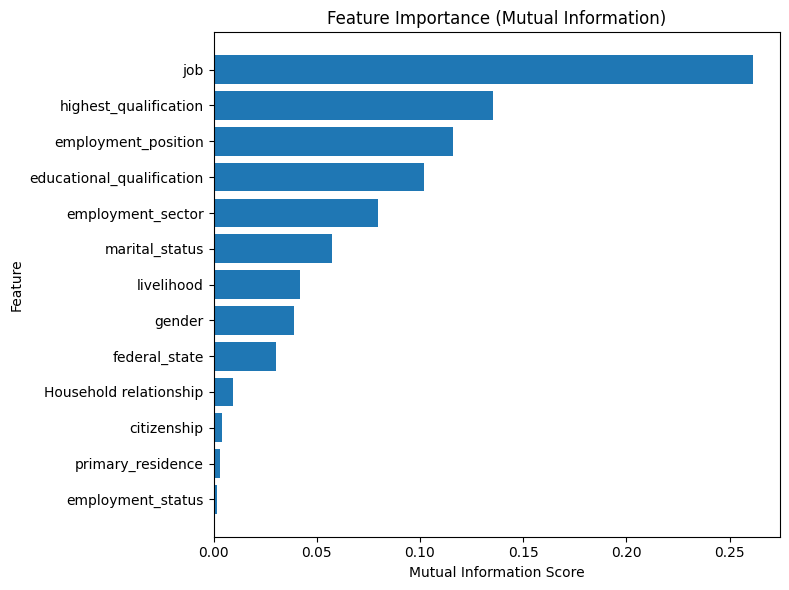

In [124]:
import matplotlib.pyplot as plt


mi_df_sorted = mi_df.sort_values(by="MI_Score", ascending=True)


plt.figure(figsize=(8, 6))
plt.barh(mi_df_sorted["Feature"], mi_df_sorted["MI_Score"])
plt.xlabel("Mutual Information Score")
plt.ylabel("Feature")
plt.title("Feature Importance (Mutual Information)")
plt.tight_layout()
plt.show()


## 2.3 Chi2 and P-Value

Chi2-Scores and P-Values for each Feature.

In [125]:
from sklearn.feature_selection import chi2
chi2_scores, p_values = chi2(X_train_raw, y_train)
chi2_df = pd.DataFrame({
    "Feature": X_train_raw.columns,
    "Chi2 Score": chi2_scores.round(2),
    "p-value": p_values.round(3)
}).sort_values(by="Chi2 Score", ascending=False)

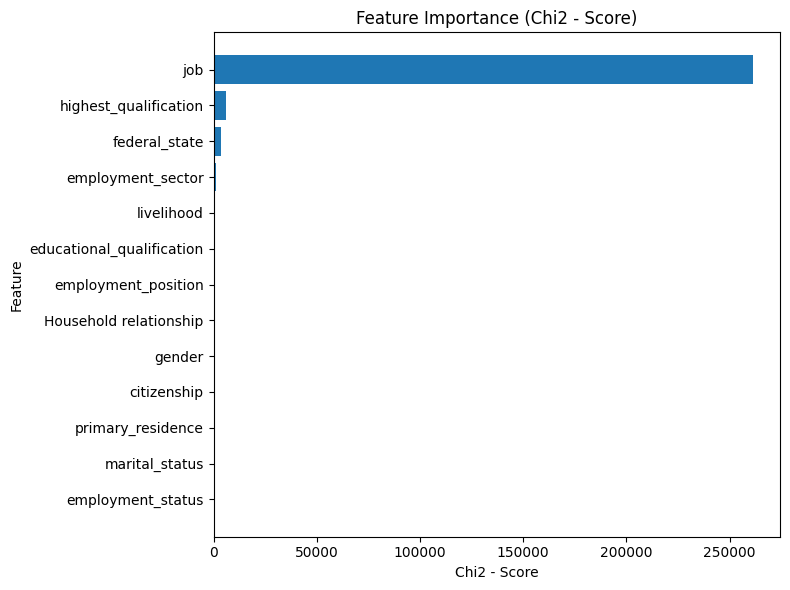

In [126]:
import matplotlib.pyplot as plt


chi2_df_sorted = chi2_df.sort_values(by="Chi2 Score", ascending=True)


plt.figure(figsize=(8, 6))
plt.barh(chi2_df_sorted["Feature"], chi2_df_sorted["Chi2 Score"])
plt.xlabel("Chi2 - Score")
plt.ylabel("Feature")
plt.title("Feature Importance (Chi2 - Score)")
plt.tight_layout()
plt.show()

## 2.4 Metric Dataframe

Combination of the metrics.

In [127]:
df_combined = df_counts.merge(mi_df, on="Feature", how="left")
df_combined = df_combined.merge(chi2_df, on="Feature", how="left")

final Dataframe featuring the feature-importance-metrics.

In [128]:
df_combined.sort_values(by="MI_Score", ascending=False)

,Feature,UniqueValues,MI_Score,Chi2 Score,p-value
6,job,103,0.261394,261312.08,0.000
10,highest_qualification,9,0.135307,5814.26,0.000
7,employment_position,10,0.115911,378.28,0.000
9,educational_qualification,9,0.101988,434.07,0.000
5,employment_sector,21,0.079924,1088.62,0.000
3,marital_status,7,0.057289,1.59,0.811
8,livelihood,9,0.041991,720.40,0.000
1,gender,2,0.039011,122.14,0.000
0,federal_state,2,0.030179,3596.89,0.000
12,Household relationship,7,0.009562,146.16,0.000


# 3. Baseline Modell Pipeline

## 3.1 Model (Naive Bayes) Pipeline

In [129]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder
from sklearn.naive_bayes import CategoricalNB
from sklearn.impute import SimpleImputer


pipe_nb = Pipeline(steps=[
    ("oe", OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=np.nan)),
    ("imputer", SimpleImputer(strategy = "most_frequent")),
    ("nb", CategoricalNB())
])

CV Definition

In [130]:
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.metrics import make_scorer, f1_score, accuracy_score


cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scoring = {
    "accuracy": make_scorer(accuracy_score),
    "f1_macro": make_scorer(f1_score, average="macro"),
    "neg_log_loss": "neg_log_loss"
}

In [131]:
def calculate_cv(pipeline, X, y, cv, scoring, show_results = True):

    cv_results   = cross_validate(pipeline, X.astype("category"), y, cv=cv, scoring=scoring)
    
    if show_results:
        for metric in scoring.keys():
            mean = cv_results[f"test_{metric}"].mean()
            std = cv_results[f"test_{metric}"].std()
            print(f"{metric}: {mean:.4f} ± {std:.4f}")

    return cv_results

## 3.2 Baseline Test

In [132]:
cv_results = calculate_cv(pipeline=pipe_nb, X=X_train_raw, y=y_train["income"], cv=cv, scoring=scoring)

accuracy: 0.5104 ± 0.0058
f1_macro: 0.4870 ± 0.0117
neg_log_loss: -1.2375 ± 0.0096


# 4 Feature Engineering

In [ ]:
def compute_feature_metrics(X, y):

    from sklearn.feature_selection import mutual_info_classif
    from sklearn.feature_selection import chi2
    import pandas as pd

     # MI
    mi_scores = mutual_info_classif(X, y, discrete_features=True, random_state=42)
    mi_df = pd.DataFrame({
        "Feature": X.columns,
        "MI_Score": mi_scores
    })

    # Chi²
    chi2_scores, p_values = chi2(X, y)
    chi2_df = pd.DataFrame({
        "Feature": X.columns,
        "Chi2_Score": chi2_scores.round(2),
        "p-value": p_values.round(3)
    })

    # Unique Values
    unique_counts = pd.DataFrame({
        "Feature": X.columns,
        "UniqueValues": [X[col].nunique() for col in X.columns]
    })

    # Merge zu einer Tabelle
    metrics_df = unique_counts.merge(mi_df, on="Feature").merge(chi2_df, on="Feature")
    metrics_df= metrics_df.sort_values(by="MI_Score", ascending=False)
    return metrics_df    

## 4.1 Job --> major job , minor job

Job is encoded (ISCO-88) -> first digit describes major job category.

In [134]:
X_train_raw["job_major"] = X_train_raw["job"].astype(str).str[0]
X_train_raw["job_minor"] = X_train_raw["job"].astype(str).str[:2]

In [135]:
metrics_df = compute_feature_metrics(X_train_raw, y_train["income"])
print(metrics_df)

                      Feature  UniqueValues  MI_Score  Chi2_Score  p-value
6                         job           103  0.261394   261312.08    0.000
14                  job_minor            27  0.190391    26038.07    0.000
13                  job_major             9  0.153149     2732.63    0.000
10      highest_qualification             9  0.135307     5814.26    0.000
7         employment_position            10  0.115911      378.28    0.000
9   educational_qualification             9  0.101988      434.07    0.000
5           employment_sector            21  0.079924     1088.62    0.000
3              marital_status             7  0.057289        1.59    0.811
8                  livelihood             9  0.041991      720.40    0.000
1                      gender             2  0.039011      122.14    0.000
0               federal_state             2  0.030179     3596.89    0.000
12     Household relationship             7  0.009562      146.16    0.000
2                 citizen

## 4.2 Cross Features

In [136]:
top_features = [
    "job_major", "highest_qualification", "employment_position",
    "educational_qualification", "employment_sector",
    "marital_status", "livelihood", "gender", "federal_state"
]

cross_df = pd.DataFrame(index=X_train_raw.index)  # leeres DF für Cross Features

for i in range(len(top_features)):
    for j in range(i+1, len(top_features)):
        col_name = f"{top_features[i]}__{top_features[j]}"
        cross_df[col_name] = (
            X_train_raw[top_features[i]].astype(str) + "_" + X_train_raw[top_features[j]].astype(str)
        )

cross_df_metrics = compute_feature_metrics(cross_df, y_train["income"])


In [137]:
print(cross_df_metrics)

                                             Feature  UniqueValues  MI_Score  \
3                       job_major__employment_sector           150  0.272821   
10          highest_qualification__employment_sector           152  0.249651   
1                     job_major__employment_position            73  0.242571   
16            employment_position__employment_sector           128  0.231960   
4                          job_major__marital_status            49  0.230814   
0                   job_major__highest_qualification            70  0.219576   
8         highest_qualification__employment_position            67  0.217525   
6                                  job_major__gender            18  0.213686   
2               job_major__educational_qualification            74  0.212664   
21      educational_qualification__employment_sector           145  0.212139   
11             highest_qualification__marital_status            49  0.211648   
15    employment_position__educational_q

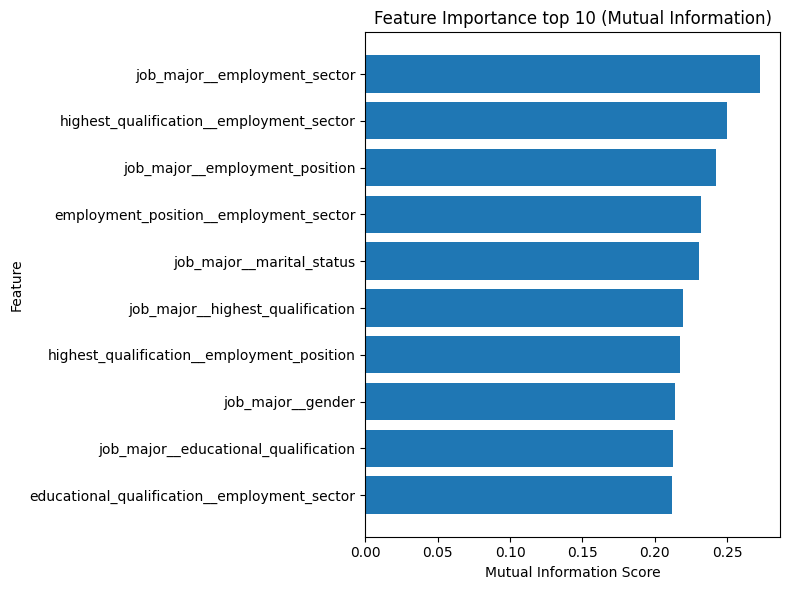

In [138]:
import matplotlib.pyplot as plt


cross_df_metrics_sorted = cross_df_metrics.sort_values(by="MI_Score", ascending=True)


plt.figure(figsize=(8, 6))
plt.barh(cross_df_metrics_sorted["Feature"].tail(10), cross_df_metrics_sorted["MI_Score"].tail(10))
plt.xlabel("Mutual Information Score")
plt.ylabel("Feature")
plt.title("Feature Importance top 10 (Mutual Information)")
plt.tight_layout()
plt.show()

# 5. Final Features and evaluation

## 5.1 Pipeline Integration

In [140]:
cross_feature_pairs = [
    ("job_major", "employment_sector"),
    ("job_major", "employment_position"),
    ("job_major", "highest_qualification"),
    ("job_major", "marital_status"),
    ("job_major", "federal_state"),
    ("job_major", "gender"),
    ("highest_qualification", "livelihood")
]

In [141]:
from sklearn.base import BaseEstimator, TransformerMixin

class CrossFeatures(BaseEstimator, TransformerMixin):
    def __init__(self, pairs):
        self.pairs = pairs

    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X_ = X.copy()
        for f1, f2 in self.pairs:
            col_name = f"{f1}__{f2}"
            X_[col_name] = X_[f1].astype(str) + "_" + X_[f2].astype(str)
        return X_



In [142]:
_ = calculate_cv(pipeline=pipe_nb, X= X_train_raw, y = y_train["income"], cv=cv, scoring=scoring)

accuracy: 0.4891 ± 0.0098
f1_macro: 0.4677 ± 0.0121
neg_log_loss: -1.6150 ± 0.0353


In [143]:
for pair in cross_feature_pairs:

    pipe_nb_fe = Pipeline(steps=[
    ("cross_feats", CrossFeatures([pair])),
    ("oe", OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=np.nan)),
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("nb", CategoricalNB())
])
    
    print(f"Pair: {pair}")
    
    cv_results = calculate_cv(pipeline=pipe_nb_fe, X=X_train_raw, y=y_train["income"], cv=cv, scoring=scoring)

Pair: ('job_major', 'employment_sector')
accuracy: 0.4818 ± 0.0082
f1_macro: 0.4614 ± 0.0098
neg_log_loss: -1.8846 ± 0.0491
Pair: ('job_major', 'employment_position')
accuracy: 0.4800 ± 0.0099
f1_macro: 0.4579 ± 0.0106
neg_log_loss: -1.8645 ± 0.0469
Pair: ('job_major', 'highest_qualification')
accuracy: 0.4806 ± 0.0062
f1_macro: 0.4573 ± 0.0070
neg_log_loss: -1.8785 ± 0.0508
Pair: ('job_major', 'marital_status')
accuracy: 0.4843 ± 0.0084
f1_macro: 0.4635 ± 0.0109
neg_log_loss: -1.8301 ± 0.0439
Pair: ('job_major', 'federal_state')
accuracy: 0.4804 ± 0.0096
f1_macro: 0.4579 ± 0.0120
neg_log_loss: -1.8598 ± 0.0535
Pair: ('job_major', 'gender')
accuracy: 0.4812 ± 0.0094
f1_macro: 0.4584 ± 0.0128
neg_log_loss: -1.8617 ± 0.0505
Pair: ('highest_qualification', 'livelihood')
accuracy: 0.4873 ± 0.0070
f1_macro: 0.4665 ± 0.0089
neg_log_loss: -1.7505 ± 0.0380


--> no Improvement. 

## 5.2 Random Forest Pipeline

In [156]:
from sklearn.ensemble import RandomForestClassifier


random_forest = RandomForestClassifier(
    n_estimators=400,
    max_depth=None,
    min_samples_leaf=1,
    class_weight="balanced_subsample",
    n_jobs=-1,
    random_state=42
)


In [163]:
pipe_rf = Pipeline(steps=[
    ("oe", OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=np.nan)),
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("rf", random_forest)
])

In [164]:
_ = calculate_cv(pipeline=pipe_rf, X= X_train_raw, y = y_train["income"], cv=cv, scoring=scoring)

accuracy: 0.7327 ± 0.0090
f1_macro: 0.7313 ± 0.0087
neg_log_loss: -0.9027 ± 0.0424


In [161]:
for pair in cross_feature_pairs:

    pipe_rf_oe = Pipeline(steps=[
    ("cross_feats", CrossFeatures([pair])),
    ("oe", OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=np.nan)),
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("rf", random_forest)
])
    
    print(f"Pair: {pair}")
    
    cv_results = calculate_cv(pipeline=pipe_rf_oe, X=X_train_raw, y=y_train["income"], cv=cv, scoring=scoring)

Pair: ('job_major', 'employment_sector')
accuracy: 0.7322 ± 0.0088
f1_macro: 0.7300 ± 0.0091
neg_log_loss: -0.9005 ± 0.0412
Pair: ('job_major', 'employment_position')
accuracy: 0.7338 ± 0.0088
f1_macro: 0.7321 ± 0.0094
neg_log_loss: -0.9179 ± 0.0446
Pair: ('job_major', 'highest_qualification')
accuracy: 0.7297 ± 0.0100
f1_macro: 0.7289 ± 0.0103
neg_log_loss: -0.9098 ± 0.0442
Pair: ('job_major', 'marital_status')
accuracy: 0.7309 ± 0.0097
f1_macro: 0.7293 ± 0.0096
neg_log_loss: -0.9163 ± 0.0784
Pair: ('job_major', 'federal_state')
accuracy: 0.7316 ± 0.0091
f1_macro: 0.7296 ± 0.0093
neg_log_loss: -0.9153 ± 0.0379
Pair: ('job_major', 'gender')
accuracy: 0.7323 ± 0.0090
f1_macro: 0.7305 ± 0.0096
neg_log_loss: -0.9013 ± 0.0553
Pair: ('highest_qualification', 'livelihood')
accuracy: 0.7320 ± 0.0097
f1_macro: 0.7312 ± 0.0100
neg_log_loss: -0.8994 ± 0.0522


--> Cross Feature Tuning does not improve the performance of random Forest or Naive Bayes classifier.